In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
mpl.rcParams['figure.figsize'] = (3, 2)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 8
mpl.rcParams['lines.linewidth'] = 1.
mpl.rcParams['figure.subplot.left'] = 0.18
mpl.rcParams['figure.subplot.bottom'] = 0.2
# sns.set(rc={'axes.facecolor':'0.95'})

sns.set_style('darkgrid')
mpl.rcParams['axes.facecolor'] = '#EFEFF5'

# Purpose of this notebook

This notebook reevalutes the analysis in Bendavid, et al. on the medRxiv (https://www.medrxiv.org/content/10.1101/2020.04.14.20062463v1) to determine how many false positives are expected to be found in the broader population of 3,300 people, given that 2 out of 401 negative tests incorrectly tested positive (were false positives).

We determine a mean of 25 people should be fale positives, with a 95% credible interval of (2, 53). The prevelance of false samples is .7% with a 95% credible interval of (0.1%, 1.6%). This credible interval includes the measured number of 50 people (prevelance of 1.5%). Is it therefore plausible that all tests were false positives. We therefore conclude that main claims of the paper, that the prevelance of COVID-19 is higher than expected, is not supported by the data.

# Useful functions

In [3]:
def credible_interval(pdf, x, alpha=0.95, plot_results=False):
    """Calculate the credible interval (CI) with the minimum area of the pdf(x).
    This function calculates the minimum value of pdf such that the
    alpha = integral of pdf(x) from x=lower_CI to x=upper_CI.
    
    This function solves for the pdf_cutoff such that
    pdf_cutoff=pdf(lower_CI)=pdf(upper_CI), and
    alpha = integral of pdf(x) over pdf > pdf_cutoff
    
    Assumes that x is equally spaced, and that pdf has only one maximum.
    
    Parameters
    ----------
    pdf: numpy array
        The probability density function is a function of x, pdf(x).
    x: numpy array
        Independent variable. Assumed to be equally spaced.
    alpha: float, optional
        The integral of pdf(x) INSIDE of the credible interval.
        Default is 0.95.
    plot_results: bool, optional
        If True, plots pdf_cutoff against the integral of pdf for values pdf > pdf_cutoff.
        Default is False.
        
    Returns
    -------
    lower_CI: float
        The lower value of the credible interval.
    upper_CI: float
        The upper value of the credible interval.
    pdf_cutoff: float
        The value of the pdf(x) such that pdf_cutoff=pdf(lower_CI)=pdf(upper_CI),
        and the integral( pdf for pdf>pdf_cutoff) = 1 - alpha.
    integrated_pdf_inside_interval: float
        This is used to verify the function ran properly. Calculates the actual
        integral of pdf inside (lower_CI, upper_CI). Should always be close to,
        but smaller than, 1 - alpha.
"""
    
    dx = x[1]-x[0]
    
    index_sorted_by_pdf = np.argsort(pdf)[::-1]
    
    pdf_cutoff = sp.interpolate.interp1d(np.cumsum(pdf[index_sorted_by_pdf]*dx),
                                         pdf[index_sorted_by_pdf])(alpha).item()
    
    lower_CI = x[np.nonzero((pdf > pdf_cutoff))[0][0]]
    upper_CI = x[np.nonzero((pdf > pdf_cutoff))[0][-1]]

    # Verify the result
    integrated_pdf_inside_interval = np.trapz(dx * pdf[(x>=lower_CI) & (x <= upper_CI)])

    if plot_results:
        plt.plot(pdf[index_sorted_by_pdf], np.cumsum(pdf[index_sorted_by_pdf]*dx))
        plt.plot(pdf_cutoff, integrated_pdf_inside_interval, 'o')
        plt.xlabel('$P(x)$')
        plt.ylabel("$\int_{P(x)}^\infty dx'\;P(x')$")
        plt.xlim(left=0)
        plt.ylim(0, 1)
    
    return lower_CI, upper_CI, pdf_cutoff, integrated_pdf_inside_interval

In [4]:
# Test code

x = np.linspace(-5, 5, 10000)
y = np.exp(-x**2/2)/np.sqrt(2*np.pi)
credible_interval(y, x, plot_results=False)

(-1.9596959695969596,
 1.9586958695869585,
 0.05847577694377084,
 0.9499101053876513)

# Data

2 false positives detected out of a total of 391 samples
Manufacturer: 2/371
Stanford: 0/30
Total: 2/391

Subsequently, 3300 indivduals were tested for the coronavirus, of which 50 tested positive.

In [5]:
false_positives_negative_test = 2
n_negative_test = 371 + 30
n_population = 3300
print("Most likely false positive rate: {:0.5f}".format(false_positives_negative_test/n_negative_test))

Most likely false positive rate: 0.00499


# Bayesian approach

## Assume flat prior distribution

The false positive rate (fpr) will be our independent variable, and the data is a fixed.

In [6]:
fpr = np.linspace(0, 1, 10000)
d_fpr = fpr[1]-fpr[0]

prior = np.ones_like(fpr)

print("Integral of prior distribution:", np.trapz(prior, x=fpr))


Integral of prior distribution: 1.0


From the prior distribution, we calculate the posterior based on a binomial model 

$$ P(fpr|data) = \frac{P(data|fpr) P(fpr)}{\int dfpr'\;P(data|fpr') P(fpr') } $$

In [7]:
def p_data_given_model(p):
    '''p is a possible false positive rate
    This return the probability of measuring the data, given a false positive rate p'''
    return sp.stats.binom(p=p, n=n_negative_test).pmf(false_positives_negative_test)

numerator = np.array([prior[i] * p_data_given_model(fpr[i]) for i in range(len(fpr))])
posterior = numerator / np.trapz(numerator, x=fpr)


(0.0, 114.53513411147134)

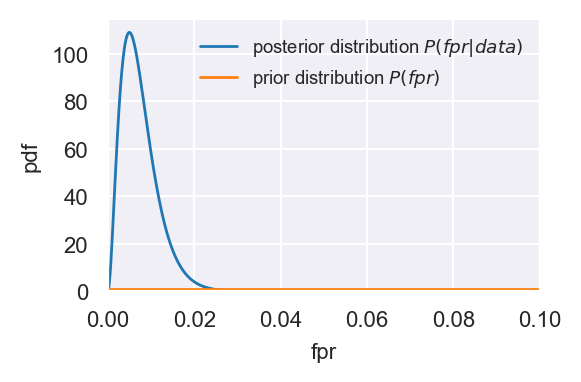

In [8]:
plt.plot(fpr, posterior, label='posterior distribution $P(fpr | data)$')
plt.plot(fpr, prior, label='prior distribution $P(fpr)$')
plt.legend(frameon=False, fontsize='small')
plt.xlabel('fpr')
plt.ylabel('pdf')
plt.xlim(0, 0.1)
plt.ylim(bottom=0)

# Credible interval of false positive rate

What area contains 95% of the posterior probability?
In this case, we'll calculate the minimal area interval.

95% CI of fpr: (0.0008, 0.0157)
Expected integral under CI: 0.95
Actual integral in CI: 0.9474


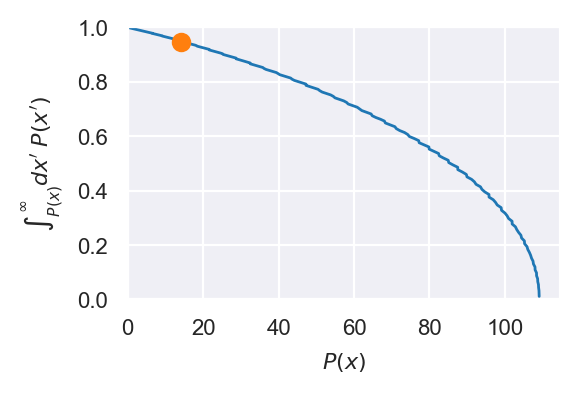

In [9]:
lower_CI_fpr,\
upper_CI_fpr,\
posterior_cutoff,\
integrated_pdf_above_cutoff,\
 = credible_interval(posterior, fpr, plot_results=True)

print("95% CI of fpr: ({:0.4f}, {:0.4f})".format(lower_CI_fpr, upper_CI_fpr))
print("Expected integral under CI:", 0.95)
print("Actual integral in CI: {:0.4f}".format(integrated_pdf_above_cutoff))

(0.0, 0.04)

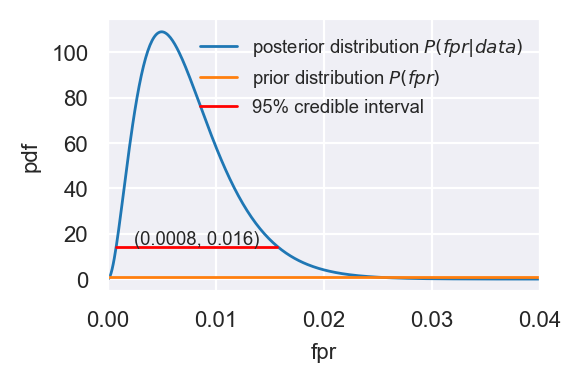

In [10]:
plt.plot(fpr, posterior, label='posterior distribution $P(fpr | data)$')
plt.plot(fpr, prior, label='prior distribution $P(fpr)$')
plt.plot([lower_CI_fpr, upper_CI_fpr], [posterior_cutoff, posterior_cutoff], 'r-', label='95% credible interval')
plt.text(0.5*(lower_CI_fpr+upper_CI_fpr),
         posterior_cutoff*1.1,
         '({:0.4f}, {:0.3f})'.format(lower_CI_fpr, upper_CI_fpr),
         horizontalalignment='center',
         fontsize='small')
plt.legend(frameon=False, fontsize='small')
plt.xticks(np.arange(0, 0.05, 0.01))
plt.xlabel('fpr')
plt.ylabel('pdf')
plt.xlim(0, 0.04)

# Distribution of false positives in the study population

Armed with the posterior distribution of false positives, we can calculate the expected number of false positives found in the larger sample population of 3,300. We do this by convolving the posterior distribution of the false positive rate with a binomial model.

$$ P(\textrm{false positive number} | \textrm{calibration data}) = \int dfpr\;P(\textrm{false positive number} | fpr ) P(fpr | data) $$

In [11]:
# n_fp is the independent variable of the number of false positives detected in the larger population.
# We will calculate the pdf_false_positive_number = P(number of false positives)

n_fp = np.arange(0, n_population+1)
pdf_false_positive_number = np.zeros_like(n_fp)

for i in range(len(fpr)):
    pdf_false_positive_number = pdf_false_positive_number \
        + d_fpr * posterior[i] * sp.stats.binom(p=fpr[i], n=n_population).pmf(n_fp)
    
print("Sum should equal 1:", np.sum(pdf_false_positive_number))

Sum should equal 1: 0.9999999999978111


In [12]:
print("Mean of distribution: {:0.1f}"\
      .format(np.sum(n_fp*pdf_false_positive_number)/np.sum(pdf_false_positive_number)))
print("Mean of distribution/n_population: {:0.4f}"\
      .format(np.sum(n_fp*pdf_false_positive_number)/(n_population*np.sum(pdf_false_positive_number))))

Mean of distribution: 24.6
Mean of distribution/n_population: 0.0074


In [13]:
lower_CI_fp_pop,\
upper_CI_fp_pop,\
pdf_cutoff,\
integral = credible_interval(pdf_false_positive_number, n_fp)

In [14]:
print("95% credible interval of false positives in population: ({:0.1f}, {:0.1f})"\
      .format(lower_CI_fp_pop, upper_CI_fp_pop))

print("95% credible interval of false positives prevelance: ({:0.3f}, {:0.3f})"\
      .format(lower_CI_fp_pop/n_population, upper_CI_fp_pop/n_population))

95% credible interval of false positives in population: (2.0, 53.0)
95% credible interval of false positives prevelance: (0.001, 0.016)


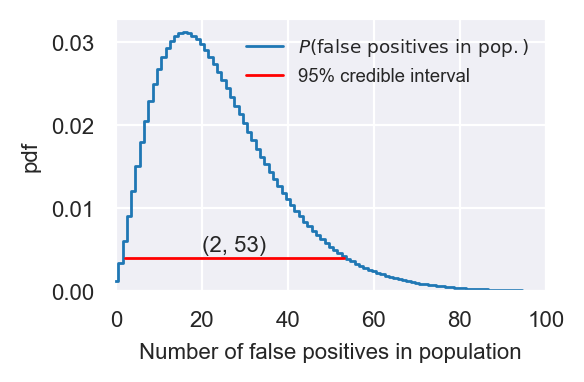

In [15]:
plt.step(n_fp-0.5, pdf_false_positive_number, where='post', label='$P(\mathrm{false\ positives\ in\ pop.})$')
plt.plot([lower_CI_fp_pop, upper_CI_fp_pop], [pdf_cutoff, pdf_cutoff], 'r-', label='95% credible interval')
plt.legend(frameon=False, fontsize='small')
plt.xlabel('Number of false positives in population')
plt.ylabel('pdf')
plt.xlim(-0.5, 100)
plt.ylim(bottom=0)
plt.text(0.5*(lower_CI_fp_pop+upper_CI_fp_pop),
         pdf_cutoff*1.2,
         "({}, {})".format(lower_CI_fp_pop, upper_CI_fp_pop),
         horizontalalignment='center',
         fontsize='medium')

plt.savefig('distribution_population_false_positives.png')

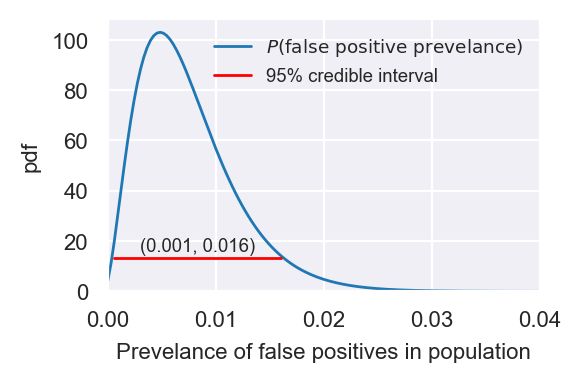

In [16]:
plt.plot(n_fp/n_population, pdf_false_positive_number*n_population, label='$P(\mathrm{false\ positive\ prevelance})$')
plt.plot([lower_CI_fp_pop/n_population, upper_CI_fp_pop/n_population],
         [pdf_cutoff*n_population, pdf_cutoff*n_population], 'r-', label='95% credible interval')
plt.legend(frameon=False, fontsize='small')
plt.xlabel('Prevelance of false positives in population')
plt.ylabel('pdf')
plt.xlim(0, 0.04)
plt.ylim(bottom=0)
plt.text(0.5*(lower_CI_fp_pop+upper_CI_fp_pop)/n_population,
         pdf_cutoff*n_population*1.2,
         "({:0.3f}, {:0.3f})".format(lower_CI_fp_pop/n_population,
                                      upper_CI_fp_pop/n_population),
         horizontalalignment='center',
         fontsize='small')

plt.savefig('distribution_population_false_positive_prevelance.png')

In [17]:
# The rest of the notebook is not finished. Terminate here.

raise Exception("Notebook not finished!")

Exception: Notebook not finished!

# Frequentist approach

Calculate errors based on the probability of finding this data, given a model of the false positive rate (fpr). $$P(data|fpr)$$.

Here we fix $fpr=fpr^*$ by finding it's most likely value:

$$fpr^\ast = \max_{fpr} P(data|fpr) = \frac{fp}{n}$$

Finally, we calculate the range of data that could be found for this value of $fpr^*$, and then calculate the range of fpr that would support this range of data.

$$ \textrm{CI of fpr} \approx \frac{\textrm{CI of }P(data|fpr^\ast)}{n} $$

In [ ]:
def p_data_given_model(p):
    '''x is a guessed false positive rate'''
    return sp.stats.binom(p=p, n=n).pmf(fp)

In [ ]:
sp.stats.binom(p=fpr_most_likely, n=n).var()

In [ ]:
fpr_most_likely = (fp/n)

print(fpr_most_likely, fpr_uncertainty)

# Assume normal distributions, the 95% confidence interval is

fpr_uncertainty = np.sqrt(fpr_most_likely/n)

print('95% CI of false positive rate:', fpr_most_likely + 1.96 * np.array([-1, 1]) * fpr_uncertainty)
print('95% CI of false positive rate:',n_samples * (fpr_most_likely + 1.96 * np.array([-1, 1]) * fpr_uncertainty))

# Range of data consistent with the most likely fpr



In [ ]:
x = np.arange(200)
p_data_most_likely_fdr = sp.stats.binom(p=fpr_most_likely, n=n).pmf(x)
print(p_data_most_likely_fdr[:5])
plt.step(-0.5+x,
         p_data_most_likely_fdr, where='post')
plt.xlim(-0.5, 20)
plt.xticks(np.arange(0, 20, 2))
plt.xlabel('')
plt.ylabel("$P(\mathrm{false\ positive\ detected}|fdr^*)$")
plt.xlabel("$\mathrm{false\ positives\ detected}$")

By inspection, the distribution is consistent with 0 false detected, so we will calculated a one-sided confidence interval.

In [ ]:
upper_CI_false_positives_detected = np.nonzero(np.cumsum(p_data_most_likely_fdr)>0.95)[0][0]
print(upper_CI_false_positives_detected)
print(sum(p_data_most_likely_fdr[:upper_CI_false_positives_detected]))

upper_CI_fpr = upper_CI_false_positives_detected / n
print(upper_CI_fpr)

upper_CI_false_positives_population = upper_CI_fpr * n_population
print(upper_CI_false_positives_population)